In [36]:
import os
import json
import h5py
import argparse
import imageio
import numpy as np
import h5py
import json
import numpy as np
import torch
import robomimic.utils.file_utils as FileUtils
import robomimic.utils.torch_utils as TorchUtils
from robomimic.algo import RolloutPolicy
from robomimic.envs.env_base import EnvBase
from copy import deepcopy
import matplotlib.pyplot as plt


import robomimic
import robomimic.utils.obs_utils as ObsUtils
import robomimic.utils.env_utils as EnvUtils
import robomimic.utils.file_utils as FileUtils
from robomimic.utils.vis_utils import depth_to_rgb
from robomimic.envs.env_base import EnvBase, EnvType
# the dataset registry can be found at robomimic/__init__.py
from robomimic import DATASET_REGISTRY
print(f"Dataset registry: {DATASET_REGISTRY}")
# Define default cameras to use for each env type
DEFAULT_CAMERAS = {
    EnvType.ROBOSUITE_TYPE: ["agentview"],
    EnvType.IG_MOMART_TYPE: ["rgb"],
    EnvType.GYM_TYPE: ValueError("No camera names supported for gym type env!"),
}


Dataset registry: {'lift': {'ph': {'raw': {'url': 'http://downloads.cs.stanford.edu/downloads/rt_benchmark/lift/ph/demo_v141.hdf5', 'horizon': 400}, 'low_dim': {'url': 'http://downloads.cs.stanford.edu/downloads/rt_benchmark/lift/ph/low_dim_v141.hdf5', 'horizon': 400}, 'image': {'url': None, 'horizon': 400}}, 'mh': {'raw': {'url': 'http://downloads.cs.stanford.edu/downloads/rt_benchmark/lift/mh/demo_v141.hdf5', 'horizon': 500}, 'low_dim': {'url': 'http://downloads.cs.stanford.edu/downloads/rt_benchmark/lift/mh/low_dim_v141.hdf5', 'horizon': 500}, 'image': {'url': None, 'horizon': 500}}, 'mg': {'raw': {'url': 'http://downloads.cs.stanford.edu/downloads/rt_benchmark/lift/mg/demo_v141.hdf5', 'horizon': 400}, 'low_dim_sparse': {'url': 'http://downloads.cs.stanford.edu/downloads/rt_benchmark/lift/mg/low_dim_sparse_v141.hdf5', 'horizon': 400}, 'image_sparse': {'url': None, 'horizon': 400}, 'low_dim_dense': {'url': 'http://downloads.cs.stanford.edu/downloads/rt_benchmark/lift/mg/low_dim_dense

In [37]:
def evaluate_on_specific_trajectory(agent_path, dataset_path, demo_index, horizon=None, render=False, video_path=None, video_skip=5, camera_names=["agentview"], seed=None):
    # Device setup
    device = TorchUtils.get_torch_device(try_to_use_cuda=True)

    # Restore policy
    policy, ckpt_dict = FileUtils.policy_from_checkpoint(ckpt_path=agent_path, device=device, verbose=True)

    # Create environment from saved checkpoint
    env, _ = FileUtils.env_from_checkpoint(
        ckpt_dict=ckpt_dict,
        env_name=None,
        render=render,
        render_offscreen=(video_path is not None),
        verbose=True,
    )

    # Set seed if provided
    if seed is not None:
        np.random.seed(seed)
        torch.manual_seed(seed)

    # Open video writer if needed
    video_writer = None
    if video_path:
        video_writer = imageio.get_writer(video_path, fps=20)

    # Open the dataset and select the specific demonstration
    with h5py.File(dataset_path, 'r') as f:
        demos = list(f["data"].keys())
        demos.sort(key=lambda x: int(x.split('_')[1]))
        demo_key = demos[demo_index]
        demo_grp = f["data"][demo_key]

        # Get the initial state of the demonstration
        state_dict = demo_grp.attrs['initial_state_dict']
        env.reset_to(state_dict)

        # Run the policy on the selected demonstration trajectory
        stats, traj = rollout(
            policy=policy,
            env=env,
            horizon=horizon or len(demo_grp["actions"]),
            render=render,
            video_writer=video_writer,
            video_skip=video_skip,
            return_obs=False,
            camera_names=camera_names,
        )

    # Close video writer if open
    if video_writer:
        video_writer.close()

    print("Evaluation on trajectory {} complete. Stats:".format(demo_index))
    print(json.dumps(stats, indent=4))
    
def rollout(policy, env, horizon, render=False, video_writer=None, video_skip=5, return_obs=False, camera_names=None):
    policy.start_episode()
    obs = env.reset()
    state_dict = env.get_state()

    # Reset the environment to the specific trajectory's initial state
    obs = env.reset_to(state_dict)

    results = {}
    video_count = 0  # video frame counter
    total_reward = 0.
    traj = dict(actions=[], rewards=[], dones=[], states=[], initial_state_dict=state_dict)
    
    try:
        for step_i in range(horizon):

            # Get action from policy
            act = policy(ob=obs)

            # Play action
            next_obs, r, done, _ = env.step(act)

            # Compute reward
            total_reward += r
            success = env.is_success()["task"]

            # Visualization
            if render:
                env.render(mode="human", camera_name=camera_names[0])
            if video_writer is not None:
                if video_count % video_skip == 0:
                    video_img = []
                    for cam_name in camera_names:
                        video_img.append(env.render(mode="rgb_array", height=512, width=512, camera_name=cam_name))
                    video_img = np.concatenate(video_img, axis=1) # concatenate horizontally
                    video_writer.append_data(video_img)
                video_count += 1

            # Collect transition
            traj["actions"].append(act)
            traj["rewards"].append(r)
            traj["dones"].append(done)
            traj["states"].append(state_dict["states"])

            # Break if done or success
            if done or success:
                break

            # Update for next iter
            obs = deepcopy(next_obs)
            state_dict = env.get_state()

    except env.rollout_exceptions as e:
        print("WARNING: got rollout exception {}".format(e))

    stats = dict(Return=total_reward, Horizon=(step_i + 1), Success_Rate=float(success))

    return stats, traj


In [39]:


dataset_path = "/home/omniverse/workspace/robomimic/datasets/lift/ph/low_dim_v141.hdf5"
dataset_path = "/home/omniverse/workspace/robomimic/datasets/lift/mg/low_dim_sparse_v141.hdf5"

# open file
f = h5py.File(dataset_path, "r")

print("hdf5 file {} has the following keys:".format(list(f.keys())))
print("data file {} has the following keys:".format(list(f["data"].keys())))
print("demo 0 {} has the following keys:".format(list(f["data"]["demo_0"].keys())))
print("Obs {} has the following keys:".format(list(f["data"]["demo_0"]["obs"].keys())))
print("states {} has the following keys:".format(list(f["data"]["demo_0"]["states"].shape)))

# each demonstration is a group under "data"
demos = list(f["data"].keys())
num_demos = len(demos)

print("hdf5 file {} has {} demonstrations".format(dataset_path, num_demos))

hdf5 file ['data'] has the following keys:
data file ['demo_1', 'demo_10', 'demo_100', 'demo_1000', 'demo_1001', 'demo_1002', 'demo_1003', 'demo_1004', 'demo_1005', 'demo_1006', 'demo_1007', 'demo_1008', 'demo_1009', 'demo_101', 'demo_1010', 'demo_1011', 'demo_1012', 'demo_1013', 'demo_1014', 'demo_1015', 'demo_1016', 'demo_1017', 'demo_1018', 'demo_1019', 'demo_102', 'demo_1020', 'demo_1021', 'demo_1022', 'demo_1023', 'demo_1024', 'demo_1025', 'demo_1026', 'demo_1027', 'demo_1028', 'demo_1029', 'demo_103', 'demo_1030', 'demo_1031', 'demo_1032', 'demo_1033', 'demo_1034', 'demo_1035', 'demo_1036', 'demo_1037', 'demo_1038', 'demo_1039', 'demo_104', 'demo_1040', 'demo_1041', 'demo_1042', 'demo_1043', 'demo_1044', 'demo_1045', 'demo_1046', 'demo_1047', 'demo_1048', 'demo_1049', 'demo_105', 'demo_1050', 'demo_1051', 'demo_1052', 'demo_1053', 'demo_1054', 'demo_1055', 'demo_1056', 'demo_1057', 'demo_1058', 'demo_1059', 'demo_106', 'demo_1060', 'demo_1061', 'demo_1062', 'demo_1063', 'demo_106

KeyError: "Unable to synchronously open object (object 'demo_0' doesn't exist)"

In [40]:
# agent = "/home/omniverse/workspace/robomimic/output/mrl_trained_models/MetricRL_2/20240828195036/models/model_epoch_2000.pth"
# dataset_path =  "/home/omniverse/workspace/robomimic/datasets/lift/ph/low_dim_v141.hdf5"

# task = "lift"
# dataset = "mg"
# agent = f"/home/omniverse/workspace/robomimic/output/mrl_trained_models_ds/MetricRL_lift_mg/20240830045713/models/model_epoch_1250.pth"
# dataset_path =  "/home/omniverse/workspace/robomimic/datasets/lift/mg/low_dim_sparse_v141.hdf5"

# demo_index = 0
# horizon = None
# render = False
# video_path = None
# video_skip = 5
# camera_names = ["agentview"]
# seed = None
# evaluate_on_specific_trajectory(
#     agent_path=agent,
#     dataset_path=dataset_path,
#     demo_index=demo_index,
#     horizon=horizon,
#     render=render,
#     video_path=video_path,
#     video_skip=video_skip,
#     camera_names=camera_names,
#     seed=seed
# )

In [55]:
def evaluate_mse_on_trajectory(policy, device, dataset_path, demo_index, plot_actions=False):

    # Open the dataset and select the specific demonstration
    with h5py.File(dataset_path, 'r') as f:
        demos = list(f["data"].keys())
        # print(demos)
        demos.sort(key=lambda x: int(x.split('_')[1]))
        demo_key = demos[demo_index]
        # print(demo_key)
        demo_grp = f["data"][demo_key]

        # Retrieve the observations and actions
        obs = {}
        for k in demo_grp["obs"]:
            obs[k] = demo_grp["obs/{}".format(k)][:]  # Get all timesteps for this modality
        
        ground_truth_actions = demo_grp["actions"][:]
        
        # print reward of the trajectory
        print("Reward of the trajectory: ", np.sum(demo_grp["rewards"][:]))

        # Get predicted actions by the model
        predicted_actions = []
        distances  = []
        print(len(ground_truth_actions))
        for t in range(len(ground_truth_actions)):
            # Prepare the observation for the model
            obs_t = {k: torch.tensor(obs[k][t],dtype=torch.float32).unsqueeze(0).to(device) for k in obs}
            g_t = {k: torch.tensor(obs[k][-1],dtype=torch.float32).unsqueeze(0).to(device) for k in obs}
            # print(obs_t["robot0_eef_pos"].shape)
            # print(g_t["robot0_eef_pos"].shape)
            # Model forward pass
            with torch.no_grad():
                act = policy(obs_t)
                z = policy.policy.nets["critic"](obs_t, g_t)
                z_g = policy.policy.nets["critic"]( g_t, g_t)
                distance = policy.policy.get_distance(z, z_g)
                distances.append(distance.cpu().numpy())    
                
            # Ensure act is a NumPy array
            if isinstance(act, torch.Tensor):
                act = act.cpu().numpy()
            
            predicted_actions.append(act)

        if plot_actions:
            predicted_actions = np.array(predicted_actions)

            # # Calculate MSE
            mse = np.mean((predicted_actions - ground_truth_actions) ** 2, axis=1)

            # Plot MSE
            plt.figure(figsize=(10, 6))
            plt.plot(mse, label='MSE between predicted and ground truth actions')
            plt.xlabel('Timestep')
            plt.ylabel('MSE')
            plt.title(f'MSE for each timestep in trajectory {demo_index}')
            plt.legend()
            plt.show()

        # plot distances from the goal of the representation
        distances = np.array(distances)
        plt.figure(figsize=(10, 6))
        plt.plot(distances, label='Distance between representation and goal')
        plt.xlabel('Timestep')
        plt.ylabel('Distance')
        plt.title(f'Distance for each timestep in trajectory {demo_index}')
        plt.legend()
        plt.show()


In [84]:
# agent = "/home/omniverse/workspace/robomimic/output/mrl_trained_models/MetricRL_2/20240823103853/models/model_epoch_2000.pth"
# agent = "/home/omniverse/workspace/robomimic/output/mrl_trained_models/MetricRL_2/20240823103853/models/model_epoch_150.pth"
agent = "/home/omniverse/workspace/robomimic/output/mrl_trained_models/MetricRL_2/20240828195036/models/model_epoch_2000.pth"
dataset_path =  "/home/omniverse/workspace/robomimic/datasets/lift/ph/low_dim_v141.hdf5"

agent = f"/home/omniverse/workspace/robomimic/output/mrl_trained_models_ds/MetricRL_lift_mg/20240830045713/models/model_epoch_1250.pth"
agent = f"/home/omniverse/workspace/robomimic/output/mrl_trained_models_ds/MetricRL_lift_mg/20240830045713/models/model_epoch_2000.pth"
agent = f"/home/omniverse/workspace/robomimic/output/mrl_trained_models/Representation_lift_mg_rep_z_64_lr_0.001_bs_1024_epochs_5000/20240903161721/models/model_epoch_5000.pth"
dataset_path =  "/home/omniverse/workspace/robomimic/datasets/lift/ph/low_dim_v141.hdf5"
demo_index = 1

# Device setup
device = TorchUtils.get_torch_device(try_to_use_cuda=True)

# Restore policy
policy, _ = FileUtils.policy_from_checkpoint(ckpt_path=agent, device=device, verbose=True)
policy.policy.set_eval()



============= Loaded Config =============
{
    "algo_name": "mrl",
    "experiment": {
        "name": "Representation_lift_mg_rep_z_64_lr_0.001_bs_1024_epochs_5000",
        "validate": false,
        "logging": {
            "terminal_output_to_txt": true,
            "log_tb": false,
            "log_wandb": true,
            "wandb_proj_name": "MetricRL"
        },
        "save": {
            "enabled": true,
            "every_n_seconds": null,
            "every_n_epochs": 50,
            "epochs": [],
            "on_best_validation": false,
            "on_best_rollout_return": false,
            "on_best_rollout_success_rate": true
        },
        "epoch_every_n_steps": 100,
        "validation_epoch_every_n_steps": 50,
        "env": null,
        "additional_envs": null,
        "render": false,
        "render_video": true,
        "keep_all_videos": true,
        "video_skip": 1,
        "rollout": {
            "enabled": false,
            "n": 50,
            "hor

Reward of the trajectory:  5.0
54


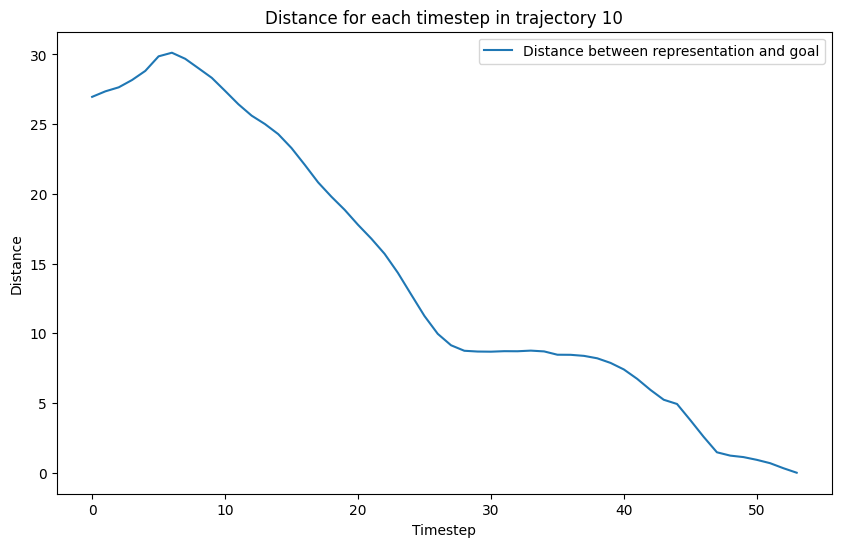

In [87]:

evaluate_mse_on_trajectory(
    policy=policy,
    device = device,
    dataset_path=dataset_path,
    demo_index=10, # 167 is bad
    plot_actions=False
)

In [16]:
agent_path = "/home/omniverse/workspace/robomimic/output/mrl_trained_models/MetricRL_2/20240823103853/models/model_epoch_2000.pth"
dataset_path =  "/home/omniverse/workspace/robomimic/datasets/lift/ph/low_dim_v141.hdf5"
demo_index = 0
# Device setup
device = TorchUtils.get_torch_device(try_to_use_cuda=True)

# Restore policy
policy, ckpt_dict = FileUtils.policy_from_checkpoint(ckpt_path=agent_path, device=device, verbose=True)

# Open the dataset and select the specific demonstration
with h5py.File(dataset_path, 'r') as f:
    demos = list(f["data"].keys())
    # print(demos)
    demos.sort(key=lambda x: int(x.split('_')[1]))
    demo_key = demos[demo_index]
    # print(demo_key)
    demo_grp = f["data"][demo_key]

    # Retrieve the observations and actions
    obs = {}
    for k in demo_grp["obs"]:
        obs[k] = demo_grp["obs/{}".format(k)][:]  # Get all timesteps for this modality
    
    ground_truth_actions = demo_grp["actions"][:]

    # Get predicted actions by the model
    predicted_actions = []
    print(len(ground_truth_actions))
    
    


============= Loaded Config =============
{
    "algo_name": "mrl",
    "experiment": {
        "name": "MetricRL_2",
        "validate": false,
        "logging": {
            "terminal_output_to_txt": true,
            "log_tb": false,
            "log_wandb": true,
            "wandb_proj_name": "MetricRL"
        },
        "save": {
            "enabled": true,
            "every_n_seconds": null,
            "every_n_epochs": 50,
            "epochs": [],
            "on_best_validation": false,
            "on_best_rollout_return": false,
            "on_best_rollout_success_rate": true
        },
        "epoch_every_n_steps": 100,
        "validation_epoch_every_n_steps": 50,
        "env": null,
        "additional_envs": null,
        "render": false,
        "render_video": true,
        "keep_all_videos": true,
        "video_skip": 1,
        "rollout": {
            "enabled": false,
            "n": 50,
            "horizon": 400,
            "rate": 50,
            "w

59


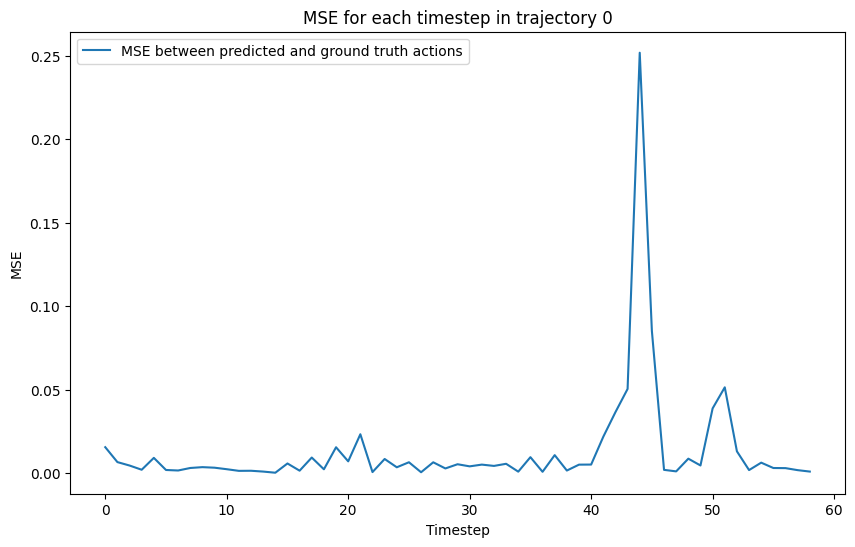

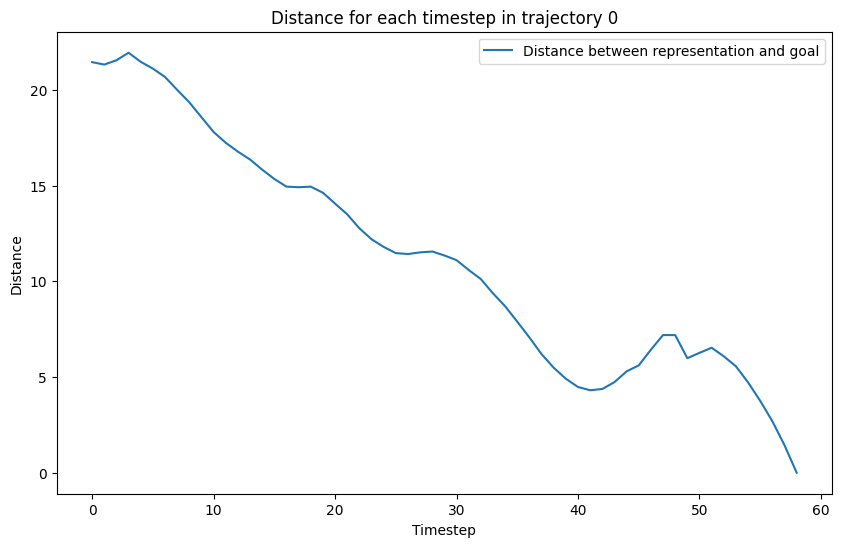

In [17]:
# Get predicted actions by the model
predicted_actions = []
distances  = []
print(len(ground_truth_actions))
for t in range(len(ground_truth_actions)):
    # Prepare the observation for the model
    obs_t = {k: torch.tensor(obs[k][t],dtype=torch.float32).unsqueeze(0).to(device) for k in obs}
    g_t = {k: torch.tensor(obs[k][-1],dtype=torch.float32).unsqueeze(0).to(device) for k in obs}
    # print(obs_t["robot0_eef_pos"].shape)
    # print(g_t["robot0_eef_pos"].shape)
    # Model forward pass
    with torch.no_grad():
        act = policy(obs_t)
        z = policy.policy.nets["critic"](obs_t)
        z_g = policy.policy.nets["critic"](g_t)
        distance = policy.policy.get_distance(z, z_g)
        distances.append(distance.cpu().numpy())    
        
    # Ensure act is a NumPy array
    if isinstance(act, torch.Tensor):
        act = act.cpu().numpy()
    
    predicted_actions.append(act)

predicted_actions = np.array(predicted_actions)

# # Calculate MSE
mse = np.mean((predicted_actions - ground_truth_actions) ** 2, axis=1)

# Plot MSE
plt.figure(figsize=(10, 6))
plt.plot(mse, label='MSE between predicted and ground truth actions')
plt.xlabel('Timestep')
plt.ylabel('MSE')
plt.title(f'MSE for each timestep in trajectory {demo_index}')
plt.legend()
plt.show()

# plot distances from the goal of the representation
distances = np.array(distances)
plt.figure(figsize=(10, 6))
plt.plot(distances, label='Distance between representation and goal')
plt.xlabel('Timestep')
plt.ylabel('Distance')
plt.title(f'Distance for each timestep in trajectory {demo_index}')
plt.legend()
plt.show()



In [39]:
policy.policy.nets.keys()



odict_keys(['actor', 'critic'])

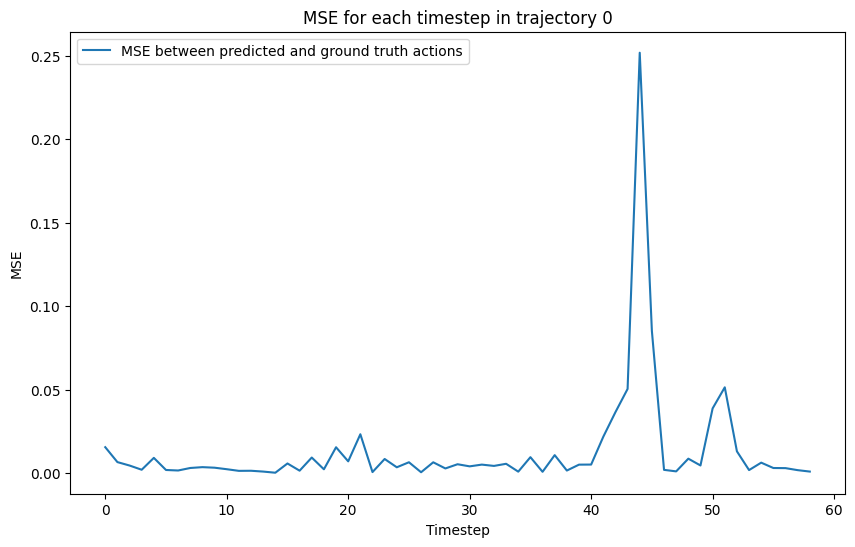